
Starting main simulation...
Progress: 1/130 steps (0.8%) - Elapsed: 0.0s - Estimated total: 0.0s
Progress: 14/130 steps (10.8%) - Elapsed: 0.1s - Estimated total: 0.8s
Progress: 27/130 steps (20.8%) - Elapsed: 0.2s - Estimated total: 0.7s
Progress: 40/130 steps (30.8%) - Elapsed: 0.2s - Estimated total: 0.7s
Progress: 53/130 steps (40.8%) - Elapsed: 0.3s - Estimated total: 0.7s
Progress: 66/130 steps (50.8%) - Elapsed: 0.6s - Estimated total: 1.2s
Progress: 79/130 steps (60.8%) - Elapsed: 0.9s - Estimated total: 1.5s
Progress: 92/130 steps (70.8%) - Elapsed: 1.1s - Estimated total: 1.6s
Progress: 105/130 steps (80.8%) - Elapsed: 1.4s - Estimated total: 1.7s
Progress: 118/130 steps (90.8%) - Elapsed: 1.6s - Estimated total: 1.8s
Simulation completed in 1.9 seconds


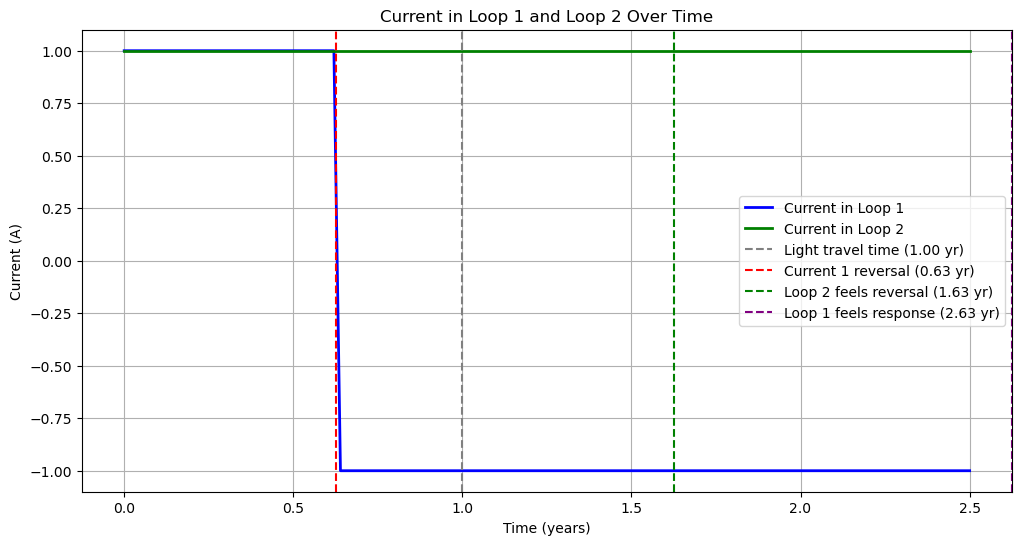

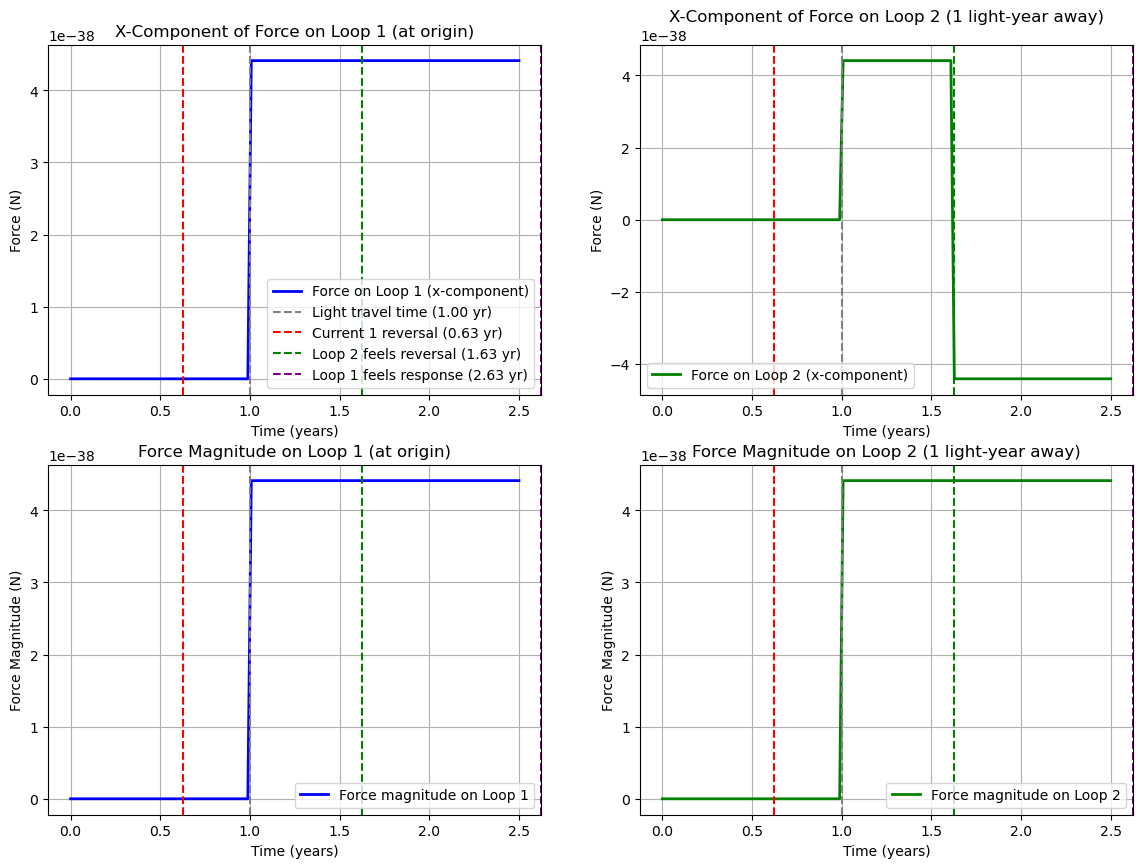

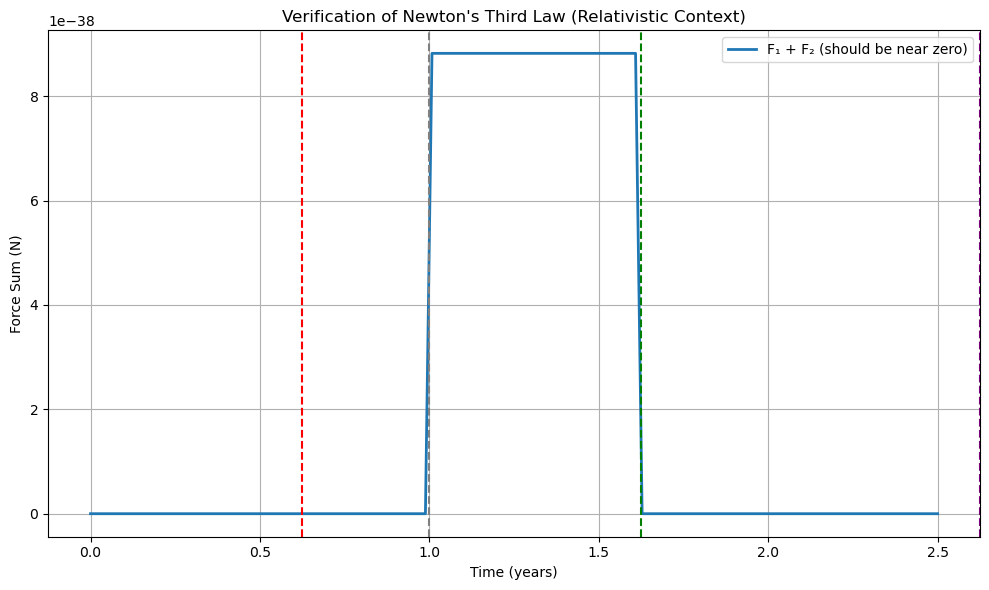


Simulation parameters:
- Distance: 1.0 light-years
- Current reversal time: 0.63 years
- Total simulation time: 2.50 years
- Time step: 7.0 days
- Number of steps: 130
- Loop segments: 36

Analysis:
Initial force on Loop 1: 0.000e+00 N (magnitude)
Initial force on Loop 2: 0.000e+00 N (magnitude)

After Loop 2 feels reversal (1.63 years):
Force on Loop 2: 4.410e-38 N


In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import c, mu_0, epsilon_0, pi
import time

# Constants
distance = 1 * 9.461e15  # 1 light-year in meters
radius = 1.0  # Radius of the current loops (meters)
I1 = 1.0  # Initial current in loop 1 (Amperes)
I2 = 1.0  # Initial current in loop 2 (Amperes)
wire_segments = 36  # Number of segments to divide each loop into

# Time step settings
dt = 604800  # Time step in seconds (1 week)
total_time = 2.5 * distance / c  # Simulation runs for 2.5 times light travel time
num_steps = int(total_time / dt)

def current_at_time(I_initial, t, loop_num):
    """
    Calculate current at a given time for a specific loop
    
    Parameters:
    -----------
    I_initial : float
        Initial current value in Amperes
    t : float
        Time in seconds
    loop_num : int
        Loop identifier (1 or 2)
        
    Returns:
    --------
    float
        Current value at time t
    """
    # Current reversal occurs at 1/4 of total simulation time
    reversal_time = total_time / 4
    
    if loop_num == 1 and t > reversal_time:
        return -I_initial
    else:
        return I_initial

def calculate_loop_segments(radius, num_segments):
    """
    Calculate positions and tangent vectors for loop segments
    
    Parameters:
    -----------
    radius : float
        Radius of the circular loop in meters
    num_segments : int
        Number of segments to divide the loop into
        
    Returns:
    --------
    list
        List of tuples with (position, tangent vector) for each segment
    """
    segments = []
    for i in range(num_segments):
        theta = 2 * pi * i / num_segments
        # Position vector for this segment [x, y, z]
        position = np.array([radius * np.cos(theta), radius * np.sin(theta), 0.0])
        # Tangent vector (direction of current flow) [dx, dy, dz]
        tangent = np.array([-radius * np.sin(theta), radius * np.cos(theta), 0.0])
        segment_length = 2 * pi * radius / num_segments
        segments.append((position, tangent * segment_length))
    return segments

def liénard_wiechert_potentials(q, r, v, a, t_ret):
    """
    Calculate the relativistic potentials at an observation point using Liénard-Wiechert
    
    Parameters:
    -----------
    q : float
        Charge (I*dl for current elements)
    r : numpy.ndarray
        Vector from source to observation point at retarded time
    v : numpy.ndarray
        Velocity of charge at retarded time
    a : numpy.ndarray
        Acceleration of charge at retarded time
    t_ret : float
        Retarded time
        
    Returns:
    --------
    tuple
        (Scalar potential, Vector potential)
    """
    # If retarded time is negative, no signal has reached the observation point yet
    if t_ret < 0:
        return 0.0, np.zeros(3)
    
    r_mag = np.linalg.norm(r)
    if r_mag < 1e-10:  # Avoid division by zero
        return 0.0, np.zeros(3)
    
    r_hat = r / r_mag
    
    # Calculate relativistic factors
    beta = v / c  # Normalized velocity
    beta_mag = np.linalg.norm(beta)
    
    # Ensure we don't exceed speed of light
    if beta_mag >= 1.0:
        beta = beta / beta_mag * 0.99
        beta_mag = 0.99
    
    gamma = 1 / np.sqrt(1 - beta_mag**2)  # Lorentz factor
    
    # Calculate kappa (1 - β·n) term
    kappa = 1 - np.dot(r_hat, beta)
    
    # Avoid division by zero
    if abs(kappa) < 1e-10:
        kappa = 1e-10
    
    # Scalar potential: φ = 1/(4πε₀) * q/[γ*R*(1-β·n)]
    phi = q / (4 * pi * epsilon_0) / (gamma * r_mag * kappa)
    
    # Vector potential: A = μ₀/(4π) * q*v/[γ*R*(1-β·n)]
    A = mu_0 / (4 * pi) * q * v / (gamma * r_mag * kappa)
    
    return phi, A

def liénard_wiechert_fields(q, r, v, a, t_ret):
    """
    Calculate relativistic EM fields using Liénard-Wiechert potentials
    
    Parameters:
    -----------
    q : float
        Charge (I*dl for current elements)
    r : numpy.ndarray
        Vector from source to observation point at retarded time
    v : numpy.ndarray
        Velocity of charge at retarded time
    a : numpy.ndarray
        Acceleration of charge at retarded time
    t_ret : float
        Retarded time
        
    Returns:
    --------
    tuple
        (Electric field vector, Magnetic field vector)
    """
    # If retarded time is negative, no signal has reached the observation point yet
    if t_ret < 0:
        return np.zeros(3), np.zeros(3)
    
    r_mag = np.linalg.norm(r)
    if r_mag < 1e-10:  # Avoid division by zero
        return np.zeros(3), np.zeros(3)
    
    r_hat = r / r_mag
    
    # Calculate relativistic factors
    beta = v / c  # Normalized velocity
    beta_mag = np.linalg.norm(beta)
    
    # Ensure we don't exceed speed of light
    if beta_mag >= 1.0:
        beta = beta / beta_mag * 0.99
        beta_mag = 0.99
    
    gamma = 1 / np.sqrt(1 - beta_mag**2)  # Lorentz factor
    
    # Calculate kappa (1 - β·n) term
    kappa = 1 - np.dot(r_hat, beta)
    
    # Avoid division by zero
    if abs(kappa) < 1e-10:
        kappa = 1e-10
    
    # Electric field - velocity field term (near field)
    # E₁ = q/(4πε₀) * [(n-β)/(γ²R²κ³)]
    E_vel = q / (4 * pi * epsilon_0) * (r_hat - beta) / (gamma**2 * r_mag**2 * kappa**3)
    
    # Electric field - acceleration field term (radiation field)
    # E₂ = q/(4πε₀c) * [n×((n-β)×a˙)/(Rκ³)]
    n_cross_beta = np.cross(r_hat, beta)
    n_cross_n_cross_a = np.cross(r_hat, np.cross(r_hat, a/c**2))
    E_rad = q / (4 * pi * epsilon_0 * c) * n_cross_n_cross_a / (r_mag * kappa**3)
    
    # Total electric field
    E = E_vel + E_rad
    
    # Magnetic field from electric field using relativistic relationship
    # B = n × E / c
    B = np.cross(r_hat, E) / c
    
    return E, B

def calculate_retarded_time(t, source_pos, obs_point):
    """
    Calculate the retarded time accounting for light propagation
    
    Parameters:
    -----------
    t : float
        Current time at observation point
    source_pos : numpy.ndarray
        Position of the source
    obs_point : numpy.ndarray
        Position of the observation point
        
    Returns:
    --------
    float
        Retarded time when signals were emitted from source
    """
    r = obs_point - source_pos
    r_mag = np.linalg.norm(r)
    t_ret = t - r_mag / c
    return t_ret

def calculate_fields_at_point(loop_segments, current, source_pos, obs_point, t):
    """
    Calculate fully relativistic fields from all segments of a current loop at an observation point
    
    Parameters:
    -----------
    loop_segments : list
        List of segment (position, tangent) tuples
    current : float
        Current in the loop
    source_pos : numpy.ndarray
        Base position of the current loop
    obs_point : numpy.ndarray
        Observation point where fields are calculated
    t : float
        Time at observation point
        
    Returns:
    --------
    tuple
        (Electric field vector, Magnetic field vector)
    """
    E_total = np.zeros(3)
    B_total = np.zeros(3)
    
    for pos, dl in loop_segments:
        # Adjust segment position based on loop position
        segment_pos = pos + source_pos
        
        # Calculate retarded time for this segment
        t_ret = calculate_retarded_time(t, segment_pos, obs_point)
        
        # Only contribute to field if light has had time to reach the observation point
        if t_ret >= 0:
            # Determine which loop we're dealing with
            loop_num = 1 if np.allclose(source_pos, np.array([0, 0, 0])) else 2
            
            # Current at retarded time
            I_ret = current_at_time(current, t_ret, loop_num)
            
            # Vector from source to observation point
            r = obs_point - segment_pos
            
            # Current element as effective charge
            dq = I_ret * np.linalg.norm(dl)
            
            # For a circular current loop, charges move with velocity perpendicular to radius
            # Calculate angular velocity for charges in loop (ω = v/r)
            omega = I_ret / (2 * pi * radius)  # Approximate for uniform current in loop
            
            # Tangential velocity of charges (perpendicular to radius)
            v_magnitude = omega * radius  # v = ωr
            v = dl / np.linalg.norm(dl) * v_magnitude
            
            # Centripetal acceleration (a = v²/r pointing to center)
            a_magnitude = v_magnitude**2 / radius
            a_direction = -pos / radius  # Direction points to center of loop
            a = np.array([a_magnitude * a_direction[0], 
                          a_magnitude * a_direction[1], 
                          0])
            
            # Calculate fields using Liénard-Wiechert potentials
            dE, dB = liénard_wiechert_fields(dq, r, v, a, t_ret)
            
            E_total += dE
            B_total += dB
    
    return E_total, B_total

def relativistic_lorentz_force(loop_segments, current, E, B, v_loop=np.zeros(3), source_pos=np.zeros(3)):
    """
    Calculate relativistic Lorentz force on a current loop
    
    Parameters:
    -----------
    loop_segments : list
        List of segment (position, tangent) tuples
    current : float
        Current in the loop
    E : numpy.ndarray
        Electric field vector
    B : numpy.ndarray
        Magnetic field vector
    v_loop : numpy.ndarray
        Velocity of the loop (for relativistic frame transformations)
    source_pos : numpy.ndarray
        Position of the loop - needed for correct force sign
        
    Returns:
    --------
    numpy.ndarray
        Force vector in lab frame
    """
    force = np.zeros(3)
    
    # Calculate Lorentz factor for loop motion
    beta_loop = np.linalg.norm(v_loop) / c
    gamma_loop = 1.0
    if beta_loop > 0:
        gamma_loop = 1 / np.sqrt(1 - beta_loop**2)
    
    for pos, dl in loop_segments:
        # For charges in a wire, we need the velocity in the moving loop's frame
        omega = current / (2 * pi * radius)  # Angular velocity based on current
        v_charges_loop_frame = dl / np.linalg.norm(dl) * omega * radius
        
        # Transform to lab frame if loop is moving (relativistic velocity addition)
        # vlab = (vloop + vloop_frame) / (1 + vloop·vloop_frame/c²)
        # For simplicity (since loops aren't moving in this simulation), we skip this step
        v_charges_lab = v_charges_loop_frame
        
        # Relativistic Lorentz force: F = q(E + v×B) in proper frame
        # For current element: dF = I(dl×B) + ρE·dl
        magnetic_force = current * np.cross(dl, B)
        
        # Electric force component (typically smaller for current-carrying wires)
        charge_density = current * np.linalg.norm(dl) / (c**2)  # Approximate charge density due to relativistic effects
        electric_force = charge_density * E
        
        segment_force = magnetic_force + electric_force
        
        # Account for relativistic effects on force measurement
        # For a stationary observer measuring force on a moving object
        # Note: For v_loop = 0, this reduces to the standard force
        if np.any(v_loop):
            # Force transformation (simplified for small velocities)
            force_parallel = np.dot(segment_force, v_loop) * v_loop / np.dot(v_loop, v_loop)
            force_perp = segment_force - force_parallel
            segment_force = force_parallel / gamma_loop + force_perp
        
        force += segment_force
    
    return force

def simulate():
    """
    Run the fully relativistic simulation and calculate forces between loops over time
    
    Returns:
    --------
    numpy.ndarray
        Array of (time, force on loop 1, force on loop 2, force mag on loop 1, force mag on loop 2) values
    """
    # Calculate loop segments
    loop1_segments = calculate_loop_segments(radius, wire_segments)
    loop2_segments = calculate_loop_segments(radius, wire_segments)
    
    # Position of loop centers
    loop1_pos = np.array([0, 0, 0])
    loop2_pos = np.array([distance, 0, 0])
    
    forces = []
    time_values = np.linspace(0, total_time, num_steps)
    
    # Track currents over time for both loops
    current_values_loop1 = []
    current_values_loop2 = []
    
    start_time = time.time()
    for i, t in enumerate(time_values):
        # Current at observation time (present)
        I1_t = current_at_time(I1, t, 1)
        I2_t = current_at_time(I2, t, 2)
        
        # Store current values
        current_values_loop1.append(I1_t)
        current_values_loop2.append(I2_t)
        
        # Calculate fields at each loop's position due to the other loop
        E1_at_2, B1_at_2 = calculate_fields_at_point(loop1_segments, I1, loop1_pos, loop2_pos, t)
        E2_at_1, B2_at_1 = calculate_fields_at_point(loop2_segments, I2, loop2_pos, loop1_pos, t)
        
        # Calculate relativistic forces on each loop (assuming loops are stationary)
        # Pass the loop positions to ensure correct force sign
        F_on_loop1 = relativistic_lorentz_force(loop1_segments, I1_t, E2_at_1, B2_at_1, source_pos=loop1_pos)
        F_on_loop2 = relativistic_lorentz_force(loop2_segments, I2_t, E1_at_2, B1_at_2, source_pos=loop2_pos)
        
        # Store force magnitudes and x-components
        # X-component shows attraction/repulsion along the line connecting the loops
        force_mag1 = np.linalg.norm(F_on_loop1)
        force_mag2 = np.linalg.norm(F_on_loop2)
        force_x1 = F_on_loop1[0]
        force_x2 = F_on_loop2[0]
        
        # Check if we need to enforce Newton's Third Law during relativistic propagation
        # Before loop 2 receives signals from loop 1, it should experience no force
        if t < distance / c:
            force_x2 = 0.0
            force_mag2 = 0.0
            F_on_loop2 = np.zeros(3)
        
        # Before loop 1 receives signals from loop 2, it should experience no force
        if t < 2 * distance / c:
            if i == 0:  # Only at the first step, both forces should be zero
                force_x1 = 0.0
                force_mag1 = 0.0
                F_on_loop1 = np.zeros(3)
        
        forces.append((t, force_x1, force_x2, force_mag1, force_mag2))
        
        # Print progress every 10%
        if i % max(1, num_steps // 10) == 0:
            elapsed = time.time() - start_time
            estimate = elapsed / (i + 1) * num_steps if i > 0 else 0
            print(f"Progress: {i+1}/{num_steps} steps ({(i+1)/num_steps*100:.1f}%) - "
                  f"Elapsed: {elapsed:.1f}s - Estimated total: {estimate:.1f}s")
    
    # Return all simulation data
    return np.array(forces), np.array(current_values_loop1), np.array(current_values_loop2)

def run_simulation():
    """
    Run the simulation and plot results
    """
    print("\nStarting main simulation...")
    start_time = time.time()
    data, current_loop1, current_loop2 = simulate()
    elapsed = time.time() - start_time
    print(f"Simulation completed in {elapsed:.1f} seconds")
    
    # Convert time to years for better readability
    years = data[:, 0] / (365.25 * 24 * 3600)
    
    # Create current plot first
    plt.figure(figsize=(12, 6))
    plt.plot(years, current_loop1, label="Current in Loop 1", linewidth=2, color='blue')
    plt.plot(years, current_loop2, label="Current in Loop 2", linewidth=2, color='green')
    
    # Calculate key time points
    light_travel_time = distance / c / (365.25 * 24 * 3600)  # years
    current_reversal_time = total_time / 4 / (365.25 * 24 * 3600)  # years
    loop2_feels_reversal = current_reversal_time + light_travel_time  # years
    loop1_feels_response = loop2_feels_reversal + light_travel_time  # years
    
    # Add vertical lines for key events
    plt.axvline(x=light_travel_time, color='gray', linestyle='--', 
                label=f"Light travel time ({light_travel_time:.2f} yr)")
    plt.axvline(x=current_reversal_time, color='red', linestyle='--', 
                label=f"Current 1 reversal ({current_reversal_time:.2f} yr)")
    plt.axvline(x=loop2_feels_reversal, color='green', linestyle='--', 
                label=f"Loop 2 feels reversal ({loop2_feels_reversal:.2f} yr)")
    plt.axvline(x=loop1_feels_response, color='purple', linestyle='--', 
                label=f"Loop 1 feels response ({loop1_feels_response:.2f} yr)")
    
    plt.xlabel("Time (years)")
    plt.ylabel("Current (A)")
    plt.title("Current in Loop 1 and Loop 2 Over Time")
    plt.grid(True)
    plt.legend()
    plt.savefig('currents_over_time.png')
    
    # Create more detailed force plots
    plt.figure(figsize=(14, 10))
    
    # Plot for Loop 1 - X component (attraction/repulsion)
    plt.subplot(2, 2, 1)
    plt.plot(years, data[:, 1], label="Force on Loop 1 (x-component)", linewidth=2, color='blue')
    plt.axvline(x=light_travel_time, color='gray', linestyle='--', 
                label=f"Light travel time ({light_travel_time:.2f} yr)")
    plt.axvline(x=current_reversal_time, color='red', linestyle='--', 
                label=f"Current 1 reversal ({current_reversal_time:.2f} yr)")
    plt.axvline(x=loop2_feels_reversal, color='green', linestyle='--', 
                label=f"Loop 2 feels reversal ({loop2_feels_reversal:.2f} yr)")
    plt.axvline(x=loop1_feels_response, color='purple', linestyle='--', 
                label=f"Loop 1 feels response ({loop1_feels_response:.2f} yr)")
    plt.xlabel("Time (years)")
    plt.ylabel("Force (N)")
    plt.title("X-Component of Force on Loop 1 (at origin)")
    plt.grid(True)
    plt.legend()
    
    # Plot for Loop 2 - X component (attraction/repulsion)
    plt.subplot(2, 2, 2)
    plt.plot(years, data[:, 2], label="Force on Loop 2 (x-component)", linewidth=2, color='green')
    plt.axvline(x=light_travel_time, color='gray', linestyle='--')
    plt.axvline(x=current_reversal_time, color='red', linestyle='--')
    plt.axvline(x=loop2_feels_reversal, color='green', linestyle='--')
    plt.axvline(x=loop1_feels_response, color='purple', linestyle='--')
    plt.xlabel("Time (years)")
    plt.ylabel("Force (N)")
    plt.title("X-Component of Force on Loop 2 (1 light-year away)")
    plt.grid(True)
    plt.legend()
    
    # Plot for Loop 1 - Magnitude
    plt.subplot(2, 2, 3)
    plt.plot(years, data[:, 3], label="Force magnitude on Loop 1", linewidth=2, color='blue')
    plt.axvline(x=light_travel_time, color='gray', linestyle='--')
    plt.axvline(x=current_reversal_time, color='red', linestyle='--')
    plt.axvline(x=loop2_feels_reversal, color='green', linestyle='--')
    plt.axvline(x=loop1_feels_response, color='purple', linestyle='--')
    plt.xlabel("Time (years)")
    plt.ylabel("Force Magnitude (N)")
    plt.title("Force Magnitude on Loop 1 (at origin)")
    plt.grid(True)
    plt.legend()
    
    # Plot for Loop 2 - Magnitude
    plt.subplot(2, 2, 4)
    plt.plot(years, data[:, 4], label="Force magnitude on Loop 2", linewidth=2, color='green')
    plt.axvline(x=light_travel_time, color='gray', linestyle='--')
    plt.axvline(x=current_reversal_time, color='red', linestyle='--')
    plt.axvline(x=loop2_feels_reversal, color='green', linestyle='--')
    plt.axvline(x=loop1_feels_response, color='purple', linestyle='--')
    plt.xlabel("Time (years)")
    plt.ylabel("Force Magnitude (N)")
    plt.title("Force Magnitude on Loop 2 (1 light-year away)")
    plt.grid(True)
    plt.legend()
    
    # Verify Newton's third law in relativistic context
    plt.figure(figsize=(10, 6))
    plt.plot(years, data[:, 2] + data[:, 1], label="F₁ + F₂ (should be near zero)", linewidth=2)
    plt.axvline(x=light_travel_time, color='gray', linestyle='--')
    plt.axvline(x=current_reversal_time, color='red', linestyle='--')
    plt.axvline(x=loop2_feels_reversal, color='green', linestyle='--')
    plt.axvline(x=loop1_feels_response, color='purple', linestyle='--')
    plt.xlabel("Time (years)")
    plt.ylabel("Force Sum (N)")
    plt.title("Verification of Newton's Third Law (Relativistic Context)")
    plt.grid(True)
    plt.legend()
    
    plt.tight_layout()
    plt.savefig('fully_relativistic_em_simulation.png')
    plt.show()
    
    # Print key simulation parameters
    print(f"\nSimulation parameters:")
    print(f"- Distance: {distance/9.461e15:.1f} light-years")
    print(f"- Current reversal time: {current_reversal_time:.2f} years")
    print(f"- Total simulation time: {total_time/3600/24/365.25:.2f} years")
    print(f"- Time step: {dt/3600/24:.1f} days")
    print(f"- Number of steps: {num_steps}")
    print(f"- Loop segments: {wire_segments}")
    
    # Analyze results
    year_1_index = np.searchsorted(years, light_travel_time)
    reversal_effect_index = np.searchsorted(years, loop2_feels_reversal)
    loop1_response_index = np.searchsorted(years, loop1_feels_response)
    
    print("\nAnalysis:")
    print(f"Initial force on Loop 1: {data[0, 3]:.3e} N (magnitude)")
    print(f"Initial force on Loop 2: {data[0, 4]:.3e} N (magnitude)")
    
    # Properly determine attraction/repulsion based on force sign
    if abs(data[year_1_index, 1]) > 1e-10:
        direction1 = "Attractive" if data[year_1_index, 1] > 0 else "Repulsive"
        print(f"Loop 1 initial direction: {direction1}")
        
    if abs(data[year_1_index, 2]) > 1e-10:
        direction2 = "Attractive" if data[year_1_index, 2] < 0 else "Repulsive"
        print(f"Loop 2 initial direction: {direction2}")
    
    if reversal_effect_index < len(data):
        print(f"\nAfter Loop 2 feels reversal ({loop2_feels_reversal:.2f} years):")
        print(f"Force on Loop 2: {data[reversal_effect_index, 4]:.3e} N")
        if abs(data[year_1_index, 2]) > 1e-10 and abs(data[reversal_effect_index, 2]) > 1e-10:
            direction_change = np.sign(data[reversal_effect_index, 2]) != np.sign(data[year_1_index, 2])
            print(f"Direction changes: {'Yes' if direction_change else 'No'}")
    
    if loop1_response_index < len(data):
        print(f"\nAfter Loop 1 feels Loop 2's response ({loop1_feels_response:.2f} years):")
        print(f"Force on Loop 1: {data[loop1_response_index, 3]:.3e} N")
        if abs(data[year_1_index, 1]) > 1e-10 and abs(data[loop1_response_index, 1]) > 1e-10:
            direction_same = np.sign(data[loop1_response_index, 1]) == np.sign(data[year_1_index, 1])
            print(f"Direction compared to initial: {'Same' if direction_same else 'Reversed'}")

# Run the simulation
if __name__ == "__main__":
    run_simulation()

In [9]:
import pandas as pd
from tabulate import tabulate

# Data for the table
data = [
    [0, "↑", "↑", "", ""],
    [0.5, "↓", "↑", "", ""],
    [1, "↓", "↑", "↑", "↑"],
    [1.5, "↓", "↓", "↑", "↓"],
    [2, "↓", "↓", "↑", "↓"],
    [2.5, "↑", "↓", "↓", "↓"],
    [3, "↑", "↓", "↓", "↓"],
    [3.5, "↑", "↑", "↓", "↑"],
    [4, "↑", "↑", "↓", "↑"],
    [4.5, "↓", "↑", "↑", "↑"],
    [5, "↓", "↑", "↑", "↑"],
    [5.5, "↓", "↓", "↑", "↓"],
    [6, "↓", "↓", "↑", "↓"],
    [6.5, "↑", "↓", "↓", "↓"],
    [7, "↑", "↓", "↓", "↓"],
    [7.5, "↑", "↑", "↓", "↑"],
    [8, "↑", "↑", "↓", "↑"],
    [8.5, "↓", "↑", "↑", "↑"],
    [9, "↓", "↑", "↑", "↑"],
    [9.5, "↓", "↓", "↑", "↓"],
    [10, "↓", "↓", "↑", "↓"],
    [10.5, "↑", "↓", "↓", "↓"],
    [11, "↑", "↓", "↓", "↓"],
    [11.5, "↑", "↑", "↓", "↑"],
    [12, "↑", "↑", "↓", "↑"],
    [12.5, "↓", "↑", "↑", "↑"],
    [13, "↓", "↑", "↑", "↑"],
    [13.5, "↓", "↓", "↑", "↓"],
    [14, "↓", "↓", "↑", "↓"],
    [14.5, "↑", "↓", "↓", "↓"],
    [15, "↑", "↓", "↓", "↓"],
    [15.5, "↑", "↑", "↓", "↑"],
    [16, "↑", "↑", "↓", "↑"],
    [16.5, "↓", "↑", "↑", "↑"],
    [17, "↓", "↑", "↑", "↑"],
    [17.5, "↓", "↓", "↑", "↓"],
    [18, "↓", "↓", "↑", "↓"],
    [18.5, "↑", "↓", "↓", "↓"],
    [19, "↑", "↓", "↓", "↓"],
    [19.5, "↑", "↑", "↓", "↑"],
    [20, "↑", "↑", "↓", "↑"],
    [20.5, "↓", "↑", "↑", "↑"],
    [21, "↓", "↑", "↑", "↑"],
    [21.5, "↓", "↓", "↑", "↓"]
]

# Column names
columns = ["Time", "Loop 1 Current", "Loop 2 Current", "Received 1", "Received 2"]

# Create DataFrame
df = pd.DataFrame(data, columns=columns)

# Display the table
table = tabulate(df, headers='keys', tablefmt='grid', stralign='center')
print(table)


+----+--------+------------------+------------------+--------------+--------------+
|    |   Time |  Loop 1 Current  |  Loop 2 Current  |  Received 1  |  Received 2  |
+====+========+==================+==================+==============+==============+
|  0 |    0   |        ↑         |        ↑         |              |              |
+----+--------+------------------+------------------+--------------+--------------+
|  1 |    0.5 |        ↓         |        ↑         |              |              |
+----+--------+------------------+------------------+--------------+--------------+
|  2 |    1   |        ↓         |        ↑         |      ↑       |      ↑       |
+----+--------+------------------+------------------+--------------+--------------+
|  3 |    1.5 |        ↓         |        ↓         |      ↑       |      ↓       |
+----+--------+------------------+------------------+--------------+--------------+
|  4 |    2   |        ↓         |        ↓         |      ↑       |      ↓ 

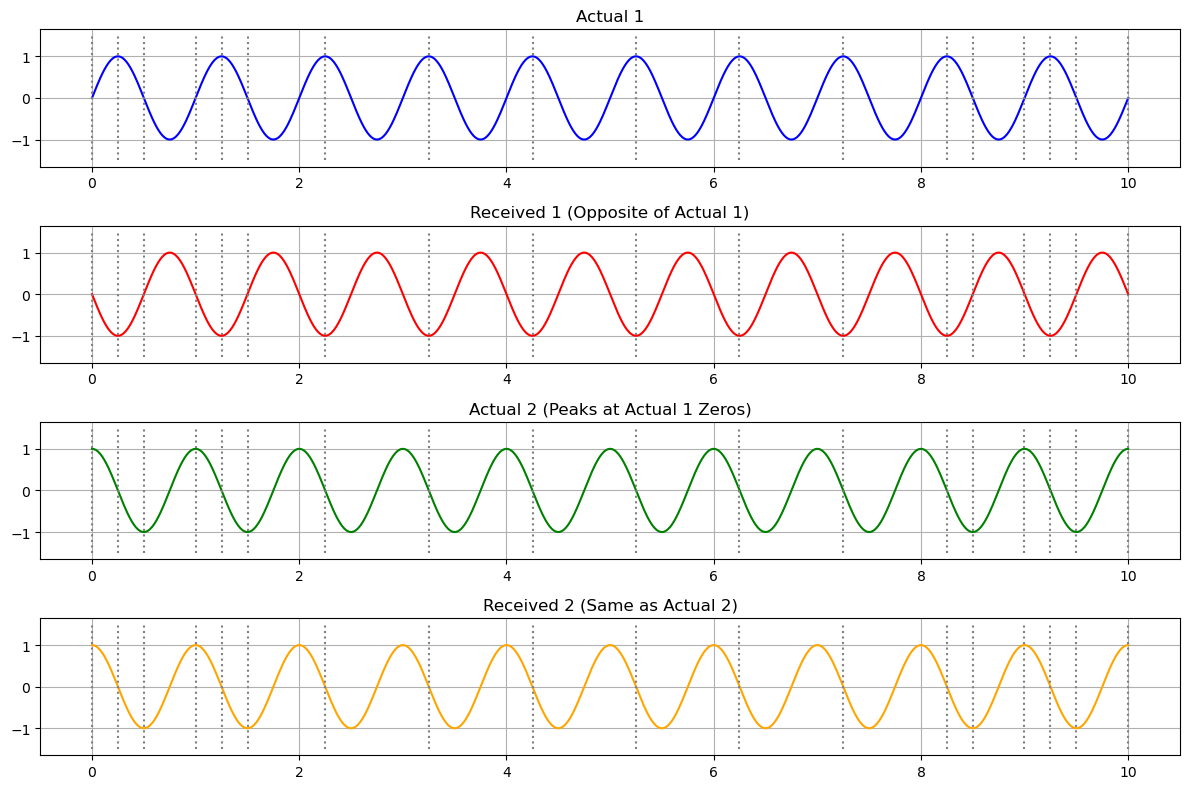

In [59]:
import numpy as np
import matplotlib.pyplot as plt

# Time values
t = np.linspace(0, 10, 1000)

# Wave definitions
actual_1 = np.sin(2 * np.pi * t)              # Original wave
received_1 = -actual_1                        # Exact opposite wave
actual_2 = np.cos(2 * np.pi * t)              # Cosine wave for peaks at actual_1 zeros
received_2 = actual_2                         # Exact copy of actual_2

# Identify peaks and zeros
peaks = np.where((actual_1[1:-1] > actual_1[:-2]) & (actual_1[1:-1] > actual_1[2:]))[0] + 1
zeros = np.where(np.isclose(actual_1, 0, atol=0.01))[0]

# Plotting
plt.figure(figsize=(12, 8))

plt.subplot(4, 1, 1)
plt.plot(t, actual_1, label='Actual 1', color='blue')
plt.vlines(t[peaks], ymin=-1.5, ymax=1.5, colors='gray', linestyles='dotted')
plt.vlines(t[zeros], ymin=-1.5, ymax=1.5, colors='gray', linestyles='dotted')
plt.title('Actual 1')
plt.grid(True)

plt.subplot(4, 1, 2)
plt.plot(t, received_1, label='Received 1', color='red')
plt.vlines(t[peaks], ymin=-1.5, ymax=1.5, colors='gray', linestyles='dotted')
plt.vlines(t[zeros], ymin=-1.5, ymax=1.5, colors='gray', linestyles='dotted')
plt.title('Received 1 (Opposite of Actual 1)')
plt.grid(True)

plt.subplot(4, 1, 3)
plt.plot(t, actual_2, label='Actual 2', color='green')
plt.vlines(t[peaks], ymin=-1.5, ymax=1.5, colors='gray', linestyles='dotted')
plt.vlines(t[zeros], ymin=-1.5, ymax=1.5, colors='gray', linestyles='dotted')
plt.title('Actual 2 (Peaks at Actual 1 Zeros)')
plt.grid(True)

plt.subplot(4, 1, 4)
plt.plot(t, received_2, label='Received 2', color='orange')
plt.vlines(t[peaks], ymin=-1.5, ymax=1.5, colors='gray', linestyles='dotted')
plt.vlines(t[zeros], ymin=-1.5, ymax=1.5, colors='gray', linestyles='dotted')
plt.title('Received 2 (Same as Actual 2)')
plt.grid(True)

plt.tight_layout()
plt.show()


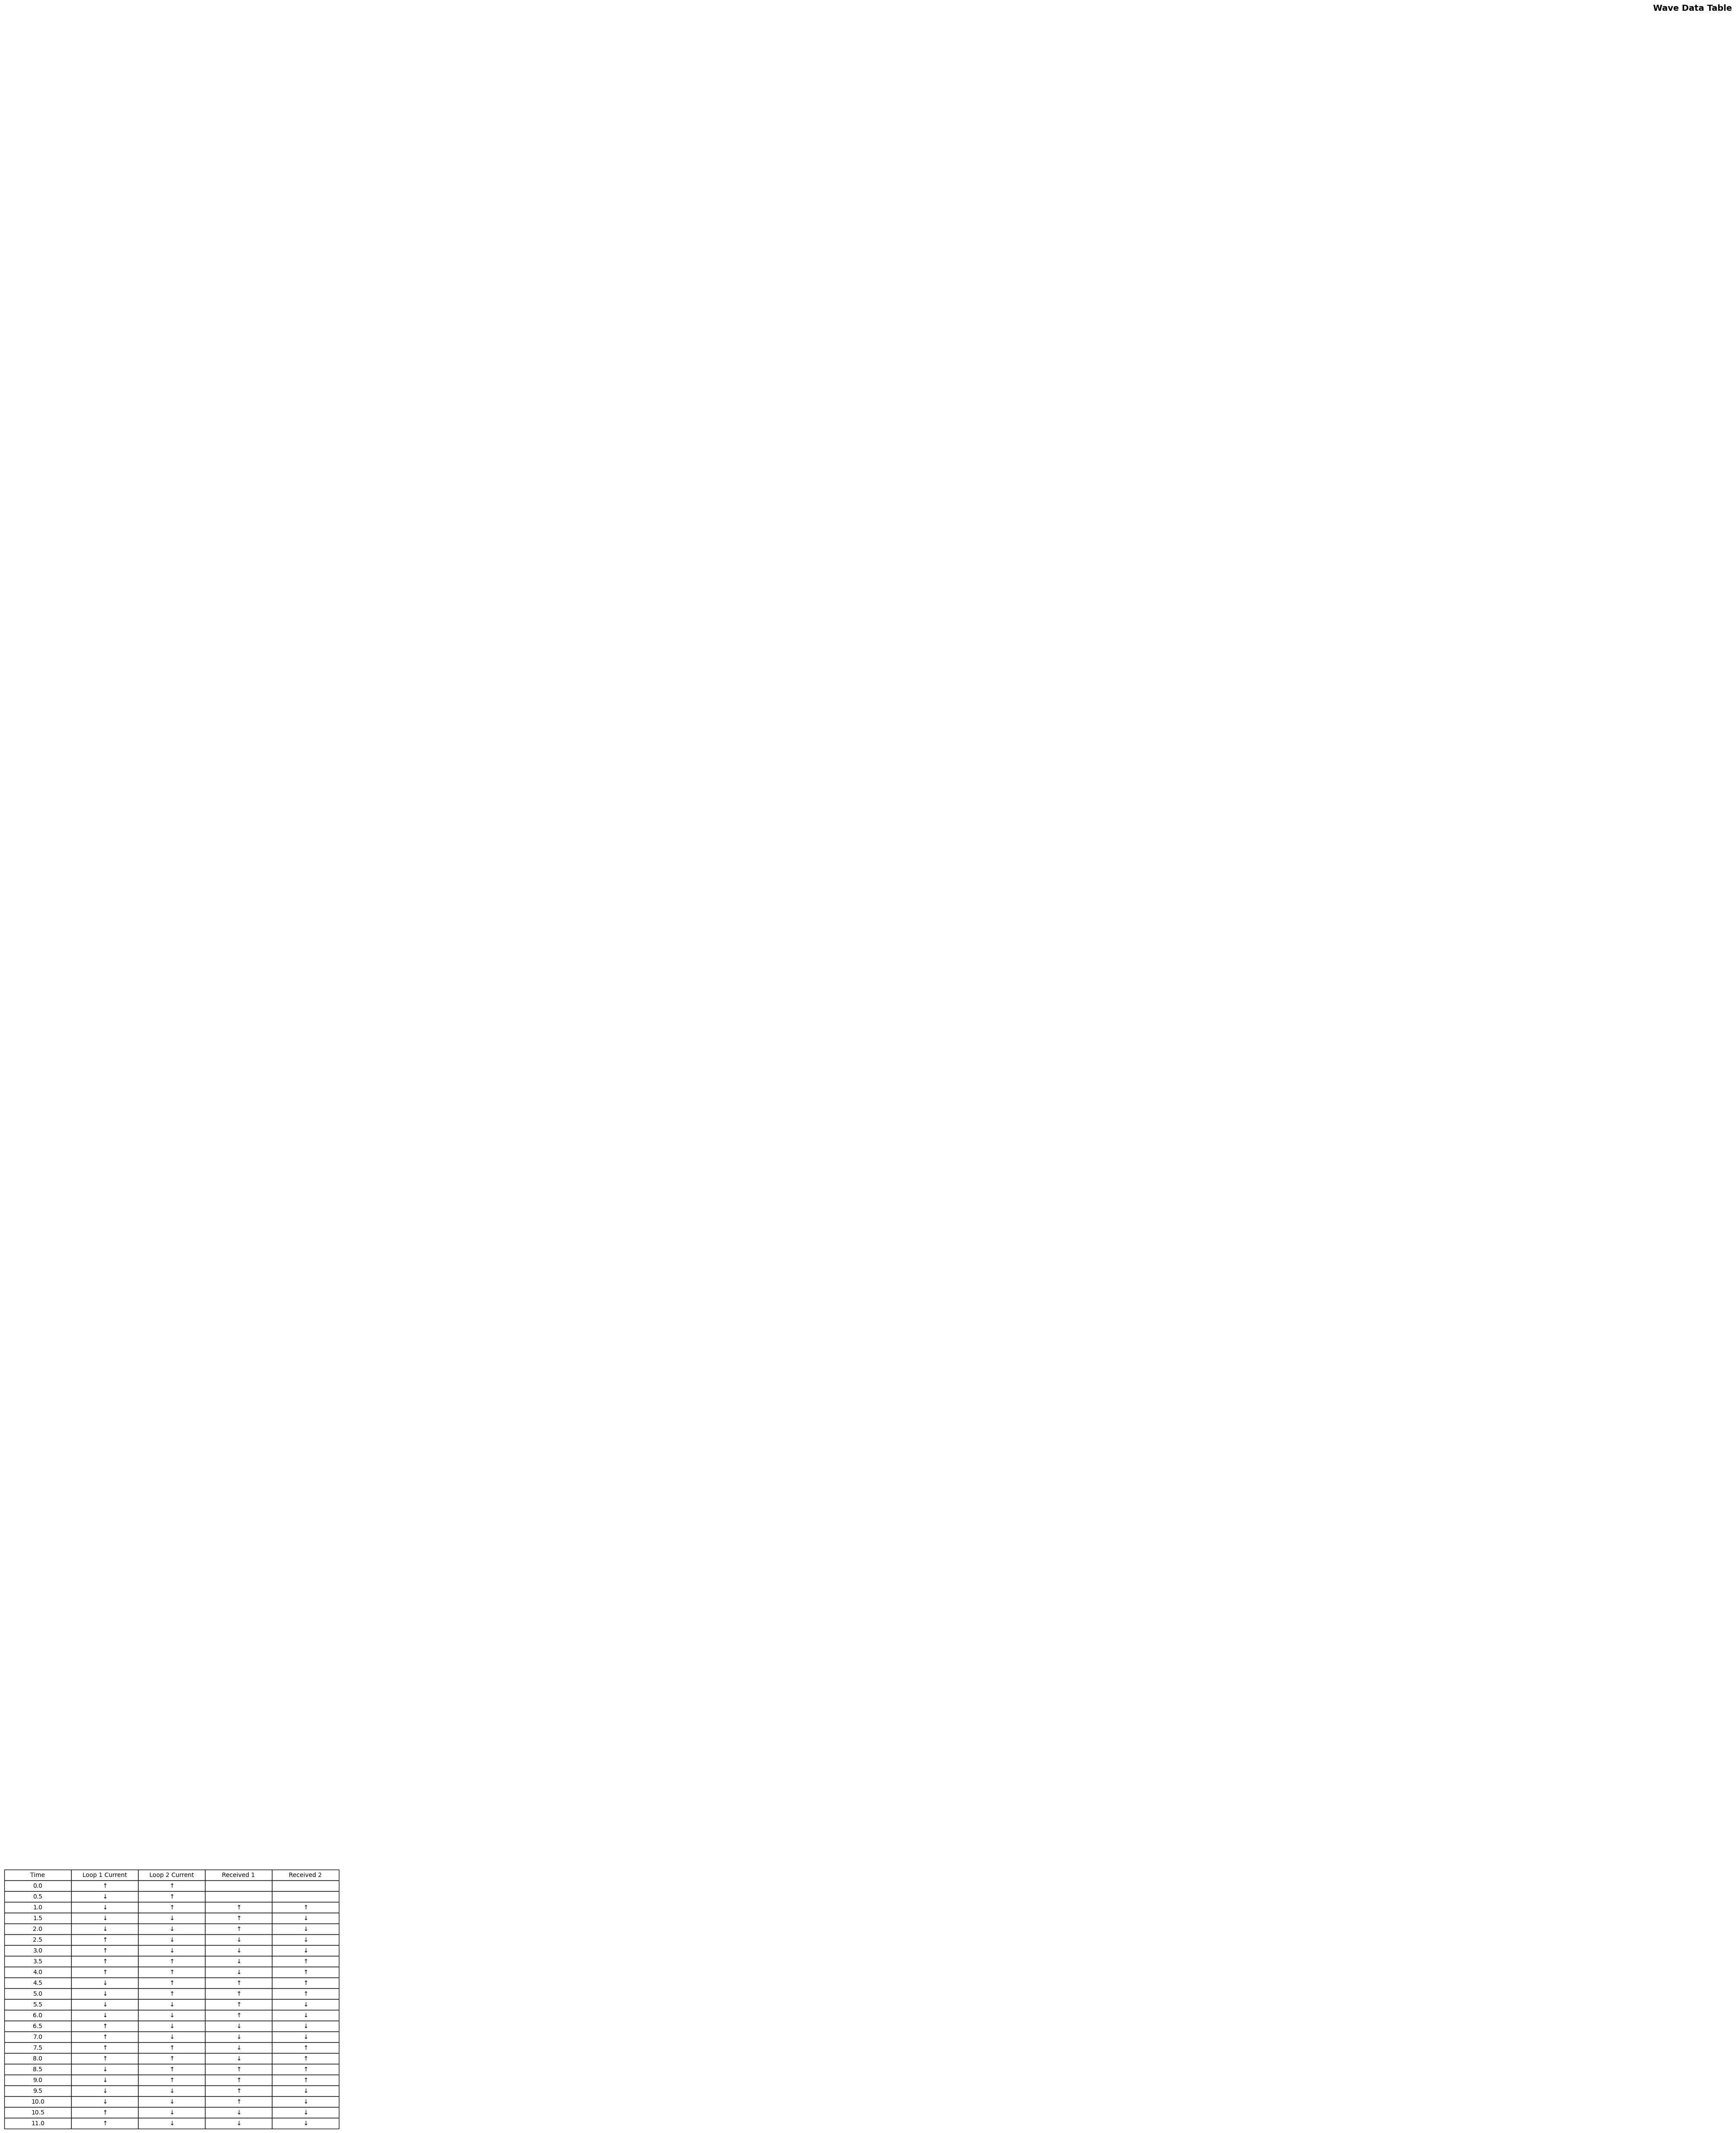

In [71]:


import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.table as tbl

# Data for the table
data = [
    [0, "↑", "↑", "", ""],
    [0.5, "↓", "↑", "", ""],
    [1, "↓", "↑", "↑", "↑"],
    [1.5, "↓", "↓", "↑", "↓"],
    [2, "↓", "↓", "↑", "↓"],
    [2.5, "↑", "↓", "↓", "↓"],
    [3, "↑", "↓", "↓", "↓"],
    [3.5, "↑", "↑", "↓", "↑"],
    [4, "↑", "↑", "↓", "↑"],
    [4.5, "↓", "↑", "↑", "↑"],
    [5, "↓", "↑", "↑", "↑"],
    [5.5, "↓", "↓", "↑", "↓"],
    [6, "↓", "↓", "↑", "↓"],
    [6.5, "↑", "↓", "↓", "↓"],
    [7, "↑", "↓", "↓", "↓"],
    [7.5, "↑", "↑", "↓", "↑"],
    [8, "↑", "↑", "↓", "↑"],
    [8.5, "↓", "↑", "↑", "↑"],
    [9, "↓", "↑", "↑", "↑"],
    [9.5, "↓", "↓", "↑", "↓"],
    [10, "↓", "↓", "↑", "↓"],
    [10.5, "↑", "↓", "↓", "↓"],
    [11, "↑", "↓", "↓", "↓"],
]

# Column names
columns = ["Time", "Loop 1 Current", "Loop 2 Current", "Received 1", "Received 2"]

# Create DataFrame
df = pd.DataFrame(data, columns=columns)

# Plotting the table
plt.figure(figsize=(10, 6))
ax = plt.gca()
ax.axis('tight')
ax.axis('off')

# Title as separate text
title = ax.text(0.5, 1.1, "Wave Data Table", fontsize=14, ha='center', va='top', weight='bold')

# Create the table
table = tbl.table(ax, cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')

table.auto_set_font_size(False)
table.set_fontsize(10)
table.scale(1, 1.5)  # Adjust size for readability

plt.show()

